# Data prepare 

This segment prepares dataset containig normalized sound recordings extended with temperature and humidity values. For now we support only one hive for data preparation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# 1300001 - hive
# 1300002 - not hive?
# 1400001 - hive szymanski
# 1400002 - hive szymanski
#hives_ids = [1300001, 1300002, 1400001, 1400002]

hives_ids = [1300001, 1300002, 1400001, 1400002]
DATA_INIT = False

night_start_hour = 21
night_end_hour = 5

In [ ]:
if DATA_INIT:
    hives_temperature = [pd.read_csv(f"measurements/{hive_id}/temperature.csv") for hive_id in hives_ids]
    hives_humidity = [pd.read_csv(f"measurements/{hive_id}/humidity.csv") for hive_id in hives_ids]
    hives_humidity = [hive_hum.drop_duplicates(subset=['timestamp'], keep = False) for hive_hum in hives_humidity]
    hives_temperature = [hive_tem.drop_duplicates(subset=['timestamp'], keep = False) for hive_tem in hives_temperature]
    
    hives_atmosphere = [pd.merge(
        hives_humidity[idx], hives_temperature[idx], on='timestamp',
        suffixes=(f"_humidity_{hive_id}",f"_temperature_{hive_id}"))
               for idx, hive_id in enumerate(hives_ids)]
   
    total = 0
    for idx, hive_atmosphere in enumerate(hives_atmosphere):
        hive_atmosphere['timestamp'] = pd.to_datetime(
            hive_atmosphere['timestamp'], format = '%Y-%m-%dT%H-%M-%S').sort_values()
        hive_atmosphere.set_index('timestamp', inplace = True)
        print(f"Hive with id: {hives_ids[idx]} has atmospheric data with size: {hive_atmosphere.shape}")
        total += hive_atmosphere.shape[0]
    
    print(f"Total atmoshpere dataset size: {total}")

In [3]:
import glob
from scipy.fftpack import rfft
from scipy.signal import blackman
import librosa

if DATA_INIT:
    total_night_samples = 0
    hives_data = []
    for idx, hive_id in enumerate(hives_ids):
        sound_files = [f for f in glob.glob(f"measurements\\{hive_id}\\sound*.csv")]
        print(f"Sound data preparation for hive: {hive_id} which has {len(sound_files)} recordings")
        for file in tqdm(sound_files):
            df_samples = pd.read_csv(file)
            pd_timestamp = pd.to_datetime(file.split("sound-")[1].split(".csv")[0], format='%Y-%m-%dT%H-%M-%S')
            if(len(df_samples.index) == 3000 and max(df_samples.values) < 4500):
                np_samples = np.array(df_samples['samples'].values, dtype="float32")
                np_samples = np_samples / 4080
                
                # FFT, get rid of DC compoment by subtracting average
                w = blackman(3000)
                np_spectogram = rfft(w*(np_samples - np.mean(np_samples)))
                np_spectogram = np.abs(np_spectogram)
                
                # MFCC
                mfccs = librosa.feature.mfcc(y=np_samples, sr=3000, n_fft=512, hop_length=256, n_mfcc=14)
                np_mfcc_avg = np.mean(mfccs, axis=1)
                np_mfcc_var = np.var(mfccs, axis=1)

                # Night label
                is_night = (pd_timestamp.hour > night_start_hour or pd_timestamp.hour < night_end_hour)
                if is_night: 
                    total_night_samples = total_night_samples + 1
                
                # Atmosphere
                df_nerest = hives_atmosphere[idx].iloc[
                    hives_atmosphere[idx].index.get_loc(pd_timestamp, method='nearest')]
                
                hives_data.append([pd_timestamp, hive_id, is_night,
                                    df_nerest[f"value_temperature_{hive_id}"],
                                    df_nerest[f"value_humidity_{hive_id}"],
                                    np_samples, np_spectogram, np_mfcc_avg, np_mfcc_var])
    
    print(f'Creating dataset with {total_night_samples} night samples for data size: {len(hives_data)}')
    print(f'Night percentage: {round(100*total_night_samples/len(hives_data), 2)}')
    np.save('hives-data.npy', hives_data)
else:
    hives_data = np.load('hives-data.npy', allow_pickle = True)
    print(f"Loaded dataset with size {len(hives_data)}.")
    
df_hives_data = pd.DataFrame(hives_data,
                           columns=['timestamp', 'hive_id', 'is_night',
                                    'temperature', 'humidity',
                                    'samples', 'fft', 'mfcc_avg', 'mfcc_var'])
df_hives_data = df_hives_data.set_index('timestamp')

Loaded dataset with size 4529.


# Temperaturowe ekstrema

In [4]:
outdoor = df_hives_data[df_hives_data.hive_id == 1300002]
df_hive_1300001 = df_hives_data[df_hives_data.hive_id == 1300001]

nearest_outdoor_idx = [outdoor.index.get_loc(df_hive_1300001.index[i], method='nearest')
                       for i in range(df_hive_1300001.shape[0])]
temperature_diffs = [abs(df_hive_1300001.iloc[i]['temperature'] - outdoor.iloc[nearest_outdoor_idx[i]]['temperature']) 
                     for i in range(df_hive_1300001.shape[0])]
df_hive_outdoor_diffs = pd.DataFrame(temperature_diffs, index=df_hive_1300001.index, columns=['temperature_diff'])

In [ ]:
df_hive_outdoor_diffs.describe()

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

hive_1300001_list = df_hive_1300001['mfcc_avg'].tolist()

hive_1300001_list_standarized = StandardScaler().fit_transform(hive_1300001_list)

hive_1300001_reduced = PCA(n_components = 2).fit_transform(hive_1300001_list) 

df_hive_1300001_reduced = pd.DataFrame(hive_1300001_reduced, index=df_hive_1300001.index, columns=['x', 'y'])

In [7]:
extreme = df_hive_outdoor_diffs[df_hive_outdoor_diffs['temperature_diff'] > 18]
normal = df_hive_outdoor_diffs[df_hive_outdoor_diffs['temperature_diff'] < 5]

df_hive_1300001_reduced_subset = df_hive_1300001_reduced[df_hive_1300001_reduced.index.isin(normal.index)
                                              | df_hive_1300001_reduced.index.isin(extreme.index)]
hive_1300001_reduced_subset_labels = df_hive_1300001_reduced_subset.index.isin(extreme.index)

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as pl

pca = PCA().fit(hive_1300001_list)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

print(np.cumsum(pca.explained_variance_ratio_[:3]))

<IPython.core.display.Javascript object>


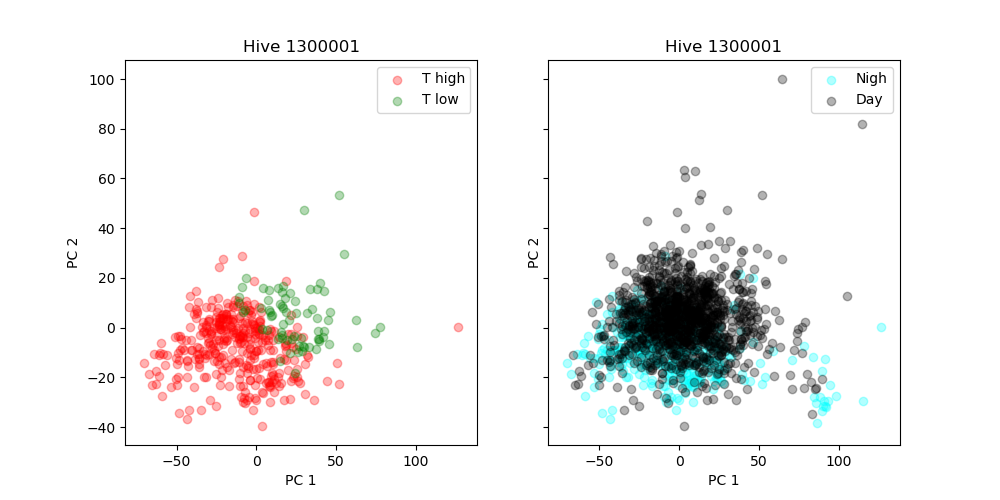

In [47]:
%matplotlib notebook
import matplotlib.pyplot as plt

df_full_night = df_hive_1300001_reduced[df_hive_1300001['is_night']]
df_full_day = df_hive_1300001_reduced[df_hive_1300001['is_night'] == False]

df_sub_extreme = df_hive_1300001_reduced_subset[hive_1300001_reduced_subset_labels]
df_sub_normal = df_hive_1300001_reduced_subset[hive_1300001_reduced_subset_labels == False]


fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
l1 = ax1.scatter([data[0] for data in df_sub_extreme.to_numpy()],
                 [data[1] for data in df_sub_extreme.to_numpy()], c='r', alpha = 0.3)
l2 = ax1.scatter([data[0] for data in df_sub_normal.to_numpy()],
                 [data[1] for data in df_sub_normal.to_numpy()], c='g', alpha = 0.3)
ax1.legend((l1, l2), ('T high', 'T low'), loc='upper right')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
ax1.set_title('Hive 1300001')

l3 = ax2.scatter([data[0] for data in df_full_night.to_numpy()],
                 [data[1] for data in df_full_night.to_numpy()], c='cyan', alpha = 0.3)
l4 = ax2.scatter([data[0] for data in df_full_day.to_numpy()],
                 [data[1] for data in df_full_day.to_numpy()], c='black', alpha = 0.3)
ax2.legend((l3, l4), ('Nigh', 'Day'), loc='upper right')
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')
ax2.set_title('Hive 1300001')
plt.show()

,x,y
timestamp,,
2019-08-03 16:07:37,42.050707,14.797378
2019-08-11 18:23:10,29.801491,47.192437
2019-08-24 16:13:22,62.977309,-7.868036
2019-08-25 12:15:22,24.284463,-18.386511
2019-08-25 12:30:22,45.519141,-6.599058
...,...,...
2019-08-28 16:08:21,3.025259,8.057390
2019-08-28 16:23:21,8.381855,6.131638
2019-08-28 16:41:21,-6.800794,20.172289


In [12]:
hive_classification_data = df_hive_1300001[df_hive_1300001.index.isin(normal.index) 
                                              | df_hive_1300001.index.isin(extreme.index)]

h131_mfcc_list = hive_classification_data['mfcc_avg'].tolist()
h131_extreme_label = hive_classification_data.index.isin(extreme.index)

### GMM

In [13]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2).fit(h131_mfcc_list)
predicted = gmm.predict(h131_mfcc_list)

correct_labels = [int(data) for data in h131_extreme_label]

sum_correct = 0
for idx, label_predicted in enumerate(predicted):
    if(label_predicted == correct_labels[idx]):
        sum_correct += 1
        
print(f'KMeans accuracy: {(sum_correct/len(correct_labels)*100)}')

KMeans accuracy: 64.47058823529412


### SVM

In [14]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf', class_weight='balanced', gamma='auto')
svc.fit(h131_mfcc_list, [int(data) for data in h131_extreme_label])
predicted = svc.predict(h131_mfcc_list)

sum_correct = 0
for idx, label_predicted in enumerate(predicted):
    if(label_predicted == correct_labels[idx]):
        sum_correct += 1
        
print(f'SVM train accuracy: {(sum_correct/len(correct_labels)*100)}')

SVM train accuracy: 100.0


## k-mean clustering

In [ ]:
df_1301 = df_hives_data[(df_hives_data.hive_id == hives_ids[0])][['is_night', 'mfcc_avg', 'temperature', 'humidity']]
df_1401 = df_hives_data[(df_hives_data.hive_id == hives_ids[1])][['is_night', 'mfcc_avg', 'temperature', 'humidity']]
df_1402 = df_hives_data[(df_hives_data.hive_id == hives_ids[2])][['is_night', 'mfcc_avg', 'temperature', 'humidity']]

In [ ]:
X_1301 = df_1301['mfcc_avg'].to_numpy()
X_1401 = df_1401['mfcc_avg'].to_numpy()
X_1402 = df_1402['mfcc_avg'].to_numpy()

X_1301_tem = df_1301['temperature'].to_numpy()
X_1401_tem = df_1401['temperature'].to_numpy()
X_1402_tem = df_1402['temperature'].to_numpy()

X_1301_hum = df_1301['humidity'].to_numpy()
X_1401_hum = df_1401['humidity'].to_numpy()
X_1402_hum = df_1402['humidity'].to_numpy()


In [ ]:
len(data_1301[0])

In [ ]:
data_1301 = []
for idx, samples in enumerate(X_1301):
    data_1301.append(np.append(samples, np.append(X_1301_tem[idx], X_1301_hum[idx])))
    
data_1401 = []
for idx, samples in enumerate(X_1401):
    data_1401.append(np.append(samples, np.append(X_1401_tem[idx], X_1401_hum[idx])))
    
data_1402 = []
for idx, samples in enumerate(X_1402):
    data_1402.append(np.append(samples, np.append(X_1402_tem[idx], X_1402_hum[idx])))

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# X_fft_values = StandardScaler().fit_transform(np.stack(df_data['fft'].values))
# X_temperature = StandardScaler().fit_transform(np.array(df_data['temperature'].values).reshape(-1, 1))
# X_humidity = StandardScaler().fit_transform(np.array(df_data['humidity'].values).reshape(-1, 1))

data_1301 = StandardScaler().fit_transform(data_1301)
data_1401 = StandardScaler().fit_transform(data_1401)
data_1402 = StandardScaler().fit_transform(data_1402)

In [ ]:
X_temperature = np.array(df_data['temperature'].values)
X_humidity = np.array(df_data['humidity'].values)
X_mfcc_avg = np.stack(df_data['mfcc_avg'].values)
X_mfcc_var = np.stack(df_data['mfcc_var'].values)
X_lpcs = np.stack(df_data['lpcs'].values)

In [ ]:
X = []
for idx, samples in enumerate(X_lpcs):
    X.append(np.append(samples, np.append(X_temperature[idx], X_humidity[idx])))

In [ ]:
X = X_lpcs

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
X_mfcc_con = np.concatenate((X_mfcc_avg, X_mfcc_var), axis = 1)
X_mfcc_con = StandardScaler().fit_transform(X_mfcc_con)

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit( )
predicted = kmeans.predict(X_fft_values)

In [ ]:
X_fft_values.shape

In [ ]:
predicted_kmean = sum(predicted)
actual = int(sum(df_data['night_label'].values))
size_data = df_data.shape[0]
print(f'Predicted with kmean: {predicted_kmean} vs {actual}/{size_data}')

In [ ]:
from sklearn.decomposition import PCA

reduced_1301 = PCA(n_components = 2).fit_transform(data_1301)
reduced_1401 = PCA(n_components = 2).fit_transform(data_1401)
reduced_1402 = PCA(n_components = 2).fit_transform(data_1402)

In [ ]:
X_reduced = []
for idx, pca_reduced in enumerate(reduced): 
    X_reduced.append(np.append(pca_reduced, np.append(X_temperature[idx], X_humidity[idx])))

X_reduced = StandardScaler().fit_transform(X_reduced)

In [ ]:
reduced_sec = PCA(n_components=2).fit_transform(X_reduced)

In [ ]:
# TSNE
from sklearn.manifold import TSNE

reduced = TSNE(n_components=2, perplexity=100, learning_rate=500, verbose=1).fit_transform(X_mfcc_avg)
reduced_sec = reduced

In [ ]:
%matplotlib notebook

fig, axs = plt.subplots(2, 2)
fig.suptitle(f'Night (from {night_start_hour}.00 to {night_end_hour}.00)/Day hives')

colors = ['red', 'green']

x_1301 = [data[0] for data in reduced_1301]
y_1301 = [data[1] for data in reduced_1301]
lab_1301 = [colors[int(data)] for data in df_1301['is_night'].values]
x_1401 = [data[0] for data in reduced_1401]
y_1401 = [data[1] for data in reduced_1401]
lab_1401 = [colors[int(data)] for data in df_1401['is_night'].values]
x_1402 = [data[0] for data in reduced_1402]
y_1402 = [data[1] for data in reduced_1402]
lab_1402 = [colors[int(data)] for data in df_1402['is_night'].values]


axs[0][0].scatter(x_1301, y_1301, c = lab_1301, alpha = 0.3)
axs[0][0].title.set_text('Ul - Starogard')
axs[0][1].scatter(x_1401, y_1401, c = lab_1401, alpha = 0.3)
axs[0][1].title.set_text('Ul - Sulmin 1')
axs[1][0].scatter(x_1402, y_1402, c = lab_1402, alpha = 0.3)
axs[1][0].title.set_text('Ul - Sulmin 2')
plt.show()


In [ ]:
df_data.head()

In [ ]:
# Import dependencies
import plotly
import plotly.graph_objs as go

colors = ['red', 'green', 'blue', 'yellow']

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

colors = [data for data in df_data['night_label'].values]
# Configure the trace.
trace = go.Scatter3d(
    x=[data[0] for data in reduced],  # <-- Put your data instead
    y=[data[1] for data in reduced],  # <-- Put your data instead
    z=[data[2] for data in reduced],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 10,
        'opacity': 0.8,
        'color': colors
    }
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

# MFCC

This block assumes that we have data in <code>df_data</code> variable.

In [ ]:
import librosa
import librosa.display

data_mfcc_labeled = []
night_timestamps = df_data.between_time("23:00", "3:30").index.values.tolist()
night_timestamps = pd.to_datetime(night_timestamps)

In [ ]:
df_data_labeled = df_data

In [ ]:
df_data_labeled.head()

In [ ]:
df_data_labeled['labeled'] = [int(index in night_timestamps) for index in df_data.index.values]

In [ ]:
for index, row in tqdm(df_data.iterrows(), total=df_data.shape[0]):
    full_mfccs = librosa.feature.mfcc(y=row['samples'], sr=3000, n_fft=512, hop_length=256, n_mfcc=14)
    data_mfcc_labeled.append([np.mean(full_mfccs,axis=1), row['temperature'], row['humidity'],
                              int(index in night_timestamps)])

# AUTOENCODER - BASIC

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as utils
import numpy as np
import pandas as pd

from tqdm import tqdm

In [ ]:
DATA_INIT = True
import glob 

auto_hives = [1300001, 1300002, 1400001, 1400002]
if DATA_INIT:
    auto_max_sample_value = 0
    auto_hive_sounds = []
    auto_hive_timestamps = []
    for idx, hive_id in enumerate(auto_hives):
        print(f"Data preparation for hive: {hive_id}")

        auto_sound_files = [f for f in glob.glob(f"measurements\\{hive_id}\\sound*.csv")]
        auto_sound_hive_list = []
        for file in tqdm(auto_sound_files):
            df_samples = pd.read_csv(file)
            pd_timestamp = pd.to_datetime(file.split("sound-")[1].split(".csv")[0], format='%Y-%m-%dT%H-%M-%S')
            if(len(df_samples.index) == 3000 and max(df_samples['samples'].values) < 4500):
                np_samples = np.array(df_samples['samples'].values, dtype="float32")
                np_samples = np_samples / 4080
                auto_hive_sounds.append([pd_timestamp, np_samples])
    np.random.shuffle(auto_hive_sounds)
    sound_pd = pd.DataFrame(auto_hive_sounds, columns=['timestamp', 'samples'])
    auto_df_data = sound_pd.set_index('timestamp')
    auto_df_data = sound_pd
else:
    sound_pd = np.load(f"{hives_ids[0]}-data.npy", allow_pickle=True)
    print(f"Loaded dataset with size {len(hive_sounds)}.")

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'We are running on : {device}')

num_epochs = 10
learning_rate = 1e-5
BATCH_SIZE = 30

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3000, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256)
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 3000), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
tensor_data = torch.FloatTensor([auto_df_data['samples'].values])
tensor_data.shape

In [ ]:
model = autoencoder()
model.to(device)

losses = []

def train(net):
    criterion = nn.MSELoss(reduction='sum')
    optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    for epoch in range(num_epochs):
        train_loss = 0
        for i in tqdm(range(0, tensor_data.size()[1], BATCH_SIZE)):
            batch_X = tensor_data[:, i:i+BATCH_SIZE, :]
            batch_X = batch_X.to(device)

            net.zero_grad()
            
            output = net(batch_X)
            loss = criterion(output, batch_X)
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item()
        # ===================log========================
        loss_per_epoch = train_loss/tensor_data.size()[1]
        print(f"epoch [{epoch}/{num_epochs}], loss:{loss_per_epoch}")
        losses.append(loss_per_epoch)

In [ ]:
train(model)

In [ ]:
%matplotlib notebook  
import matplotlib.pyplot as plt


plt.plot(losses)
plt.title("Autoencoder loss")
plt.show()

In [ ]:
torch.save(model.state_dict(), 'autoencoder-06-11-2019-model.pth')

In [ ]:
sound_tensors = torch.FloatTensor([df_data_labeled['samples'].values])

In [ ]:
sss = list(zip(sound_tensors, df_data_labeled['labeled'].values))

In [ ]:
with torch.no_grad():
    sound_tensors = sound_tensors.to(device)
    output = model.encoder(sound_tensors)
    output = output.squeeze(0)

In [ ]:
output.shape

In [ ]:
output_cpu = output.cpu()

In [ ]:
labels_list_val = df_data_labeled['labeled'].values

In [ ]:
len(labels)

# Basic classification PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
#standarized_mfcc_avg = StandardScaler().fit_transform([data[0] for data in data_mfcc_labeled])
#standarized_temp = StandardScaler().fit_transform([[data[1]] for data in data_mfcc_labeled])
#standarized_hum = StandardScaler().fit_transform([[data[2]] for data in data_mfcc_labeled])

standarized_autoencoder = StandardScaler().fit_transform(output.cpu())

#zipped_data = list(zip(standarized_mfcc_avg, standarized_temp, standarized_hum))
#merged_data = [np.concatenate(list_to_con) for list_to_con in zipped_data]
#standarized_merged_data = StandardScaler().fit_transform(merged_data)

pca = PCA(n_components=2)
pc_data = pca.fit_transform(standarized_autoencoder)

# Basic classification t-sne

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(output_cpu)

# Visualize

In [ ]:
len(pc_data[0])

In [ ]:
#pc_data_labeled = list(zip(pc_data, [mfcc_data[3] for mfcc_data in data_mfcc_labeled]))
colors = ['red', 'green', 'blue', 'yellow']
labels = ['day', 'night']

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)

# ax.scatter(x=[data[0][0] for data in pc_data_labeled],
#            y=[data[0][1] for data in pc_data_labeled],
#            c=[colors[int(data[1])] for data in pc_data_labeled],
#           alpha=0.3) 
ax.scatter(x=[data[0] for data in pc_data],
           y=[data[1] for data in pc_data],
           #c=[colors[data] for data in labels_list_val],
          alpha=0.3)
ax.legend()

plt.title("Autoencoder scatter plot")
plt.show()

### Evaluation

In [ ]:
model.load_state_dict(torch.load('autoencoder-06-11-2019-model.pth'))
model.to(device)

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='mnist', train=True,
                                   download=False, transform=transform)
test_data = datasets.MNIST(root='mnist', train=False,
                                  download=False, transform=transform)

# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # linear layer (784 -> encoding_dim)
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        
        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(encoding_dim, 28*28)
        

    def forward(self, x):
        # add layer, with relu activation function
        x = F.relu(self.fc1(x))
        # output layer (sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.fc2(x))
        return x

# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim).to(device)
print(model)

# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 20


for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1).to(device)
        print(images.shape)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        print(images.size(0))
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

In [ ]:
def lpc(y, m):
    "Return m linear predictive coefficients for sequence y using Levinson-Durbin prediction algorithm"
    #step 1: compute autoregression coefficients R_0, ..., R_m
    R = [y.dot(y)] 
    if R[0] == 0:
        return [1] + [0] * (m-2) + [-1]
    else:
        for i in range(1, m + 1):
            r = y[i:].dot(y[:-i])
            R.append(r)
        R = np.array(R)
    #step 2: 
        A = np.array([1, -R[1] / R[0]])
        E = R[0] + R[1] * A[1]
        for k in range(1, m):
            if (E == 0):
                E = 10e-17
            alpha = - A[:k+1].dot(R[k+1:0:-1]) / E
            A = np.hstack([A,0])
            A = A + alpha * A[::-1]
            E *= (1 - alpha**2)
        return A